<a href="https://colab.research.google.com/github/wilmi94/MasterThesis-AE/blob/main/notebooks/sdo_bin_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Binary Classification of full-disk SDO/AIA Data

> This notebook is part of the Master Thesis *Predicting Coronal Mass Ejections using Machine Learning methods* by Wilmar Ender, FH Wiener Neustadt, 2023.

This notebook is part of the Data Exploration phase (section 4.3 in thesis) and aims to apply a simple binary image classifier on the used SDO/AIA dataset.

**Question:** \\
Is it possible to classifiy a Flare which will be associated with a CME?

**Objectives:** \\
* perform data exploration and getting used to the dataset
* develop helper functions and code for subsequent prediction model
* test and apply "simple" binary classification models
* evaluate the models to get a baseline in terms of performance.

**Solar event list:** \\
The solar event list is taken from the following paper: \\
*Liu et al. 2020, Predicting Coronal Mass Ejections Using SDO/HMI Vector Magnetic Data Products and Recurrent Neural Networks* \\
This list/catalog conists of:
* 129 M- and X-class Flares that are associated with CMEs and
* 610 M- and X-class Flares that are **not** associated with CMEs.

**Image Dataset:** \\
The used Image Data is taken from the following paper: \\
*Ahmadzadeh et al. 2019, A Curated Image Parameter Data Set from the Solar Dynamics Observatory Mission*. \\
The data iself is accessed via the so-called *sdo-cli* (https://github.com/i4Ds/sdo-cli) developed by Marius Giger.


## Setting up the Notebook

In [1]:
%%capture
pip install -U sdo-cli

In [2]:
from pathlib import Path
import os
import requests
import subprocess
import shutil
import random

import numpy as np
import pandas as pd
import itertools
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, auc

import keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import VGG16
from keras.layers import Activation, Dropout, Flatten, Conv2D, MaxPooling2D, Dense
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.layers import Input, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report





In [3]:
# mount Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Change present working directory
%cd /content/drive/MyDrive/Academia/MSc. Aerospace Engineering - FH Wiener Neustadt/4. Master Thesis/03-Work/

/content/drive/MyDrive/Academia/MSc. Aerospace Engineering - FH Wiener Neustadt/4. Master Thesis/03-Work


In [5]:
!ls -a

 00_Dataset		   03_sdo_ConvLSTM			      .sdo-cli
 01_sdo_data_exploration   04_Tests
 02_sdo_binclass	  'Master Thesis-ML-Project-Checklist.gdoc'


## Helper Functions

In [6]:
def create_sdo_aia_dataset(output_dir, start_idx, event_list, dt, wavelength ):
  '''
  download with the help of sdo-cli AIA images wrt. wavelength and time timeinterval
  Note: this function can be adjusted such that the start, end time and intervall could be separately adjusted.
  input:
  output_dir = as a string where the images should be saved (repository path)
  eventlist  = dataframe which provides CME data like start, peak and end time
  start_idx  = from where the query should start
  dt         = string, time step between images (if possible), e.g. '6min'
  wavelength = string, corresponing wavelegth channel of AIA e.g. '171' for 171 Angström channel

  output:
  images (51x512) within folder output_dir folder
  '''

  for idx in range(start_idx, event_list.shape[0]):
    start_time = event_list['Peak Time'][idx]
    end_time = start_time
    command = f"sdo-cli data download --path={output_dir} --start={start_time} --end={end_time} --freq={dt} --wavelength={wavelength}"
    subprocess.call(command, shell=True)
    print("\r", idx, ': downloading CME from ', start_time, end="")

In [7]:
def compare_filenames_with_dataframe(directory, dataframe, wavelength):
  '''
  compare the filenames within a folder with a provided list.

  input:
  directory  = string where the images are saved (repository path)
  dataframe  = a dataframe where the events/images are stored
  wavelength = wavelength challel (only for filename neccessary)

  output:
  statistics = a dictionary where statistical data is stored
  df_missing = a dataframe with all the missing images
  '''


  file_end = '_' + str(wavelength) + '.jpeg'
  # Get list of filenames from the directory
  directory_filenames = [filename for filename in os.listdir(directory) if filename.endswith(file_end)]

  # Get list of names from the DataFrame
  df_check = dataframe.copy()
  df_check['Peak Time'] = pd.to_datetime(df_check['Peak Time']).dt.strftime('%Y-%m-%dT%H%M%S__171.jpeg') # Warning! wavelength is now hard coded

  dataframe_names = df_check['Peak Time'].tolist()  # the name of the image should correspond to the timestamp

  # Compare filenames
  common_filenames = set(directory_filenames) & set(dataframe_names)
  missing_filenames = set(dataframe_names) - set(directory_filenames)
  extra_filenames = set(directory_filenames) - set(dataframe_names)

  df_missing = pd.DataFrame (data = missing_filenames,  columns=['Peak Time'])
  df_missing['Peak Time'] = df_missing['Peak Time'].str.replace(r'__171.jpeg', '', regex=True)
  df_missing['Peak Time'] = pd.to_datetime(df_missing['Peak Time']).dt.strftime('%Y-%m-%dT%H:%M:%S')

  # Calculate statistics
  total_directory_files = len(directory_filenames)
  total_dataframe_names = len(dataframe_names)
  total_common_files = len(common_filenames)
  total_missing_files = len(missing_filenames)
  total_extra_files = len(extra_filenames)
  print('Total Directory Files: ', total_directory_files)
  print('Total DataFrame Names: ', total_dataframe_names)
  print('Common Files: ', total_common_files)
  print('Missing Files: ', total_missing_files)
  print('Extra Files: ', total_extra_files)

  statistics = {
      'Total Directory Files': total_directory_files,
      'Total DataFrame Names': total_dataframe_names,
      'Common Files': total_common_files,
      'Missing Files': total_missing_files,
      'Extra Files': total_extra_files,
      #'Common File Names': common_filenames,
      'Missing File Names': missing_filenames,
      'Extra File Names': extra_filenames
  }

  return statistics, df_missing

In [8]:
def load_and_augment_data(directory, label):
    image_data = []
    label_data = []
    num_samples = len(os.listdir(directory))
    file_list = os.listdir(directory)[:num_samples]
    for filename in file_list:
        img = tf.keras.preprocessing.image.load_img(os.path.join(directory, filename), target_size=input_shape[:2])
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = datagen.random_transform(img_array)
        image_data.append(img_array)
        label_data.append(label)
    return np.array(image_data), np.array(label_data)

In [9]:
def evaluate_model(y_true, y_pred_prob):
    """
    Calculate and plot ML evaluation metrics.

    Parameters:
    y_true (array-like): True binary labels (0 or 1).
    y_pred_prob (array-like): Predicted probabilities of class 1.

    Returns:
    None (displays plots).
    """
    # Calculate binary predictions
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    classes = ["Negative", "Positive"]
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy:.2f}")

    # Precision
    precision = precision_score(y_true, y_pred)
    print(f"Precision: {precision:.2f}")

    # Recall
    recall = recall_score(y_true, y_pred)
    print(f"Recall: {recall:.2f}")

    # F1 Score
    f1 = f1_score(y_true, y_pred)
    print(f"F1 Score: {f1:.2f}")

    # ROC Curve and ROC AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    roc_auc = roc_auc_score(y_true, y_pred_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

## Get Solar Events

The following list (stored as a .csv file) from *Liu et al. 2020* holds all the events (129) and non-events (610) presented in the study. \\
First, the csv file is imported and stored as a pandas dataframe.


In [10]:
# load list with both (neg, pos) labels
df_events = pd.read_csv(r'00_Dataset/event_lists/all_cme_events.csv', delimiter =';')
# show numer of events and display the first twelfe samples
print('There are', df_events.shape[0], 'events stored in the list.\n')
df_events.head(12)

There are 739 events stored in the list.



,Flare Class,Start Time,Peak Time,End Time,Active Region Number,Harp Number,CME
0,M1.2,2010-05-05T17:13Z,2010-05-05T17:19Z,2010-05-05T17:22Z,11069,8,No
1,M1.0,2010-06-13T05:30Z,2010-06-13T05:39Z,2010-06-13T05:44Z,11079,49,No
2,M2.0,2010-06-12T00:30Z,2010-06-12T00:57Z,2010-06-12T01:02Z,11081,54,No
3,M1.0,2010-08-07T17:55Z,2010-08-07T18:24Z,2010-08-07T18:47Z,11093,115,No
4,M2.9,2010-10-16T19:07Z,2010-10-16T19:12Z,2010-10-16T19:15Z,11112,211,No
5,M5.4,2010-11-06T15:27Z,2010-11-06T15:36Z,2010-11-06T15:44Z,11121,245,No
6,M1.6,2010-11-04T23:30Z,2010-11-04T23:58Z,2010-11-05T00:12Z,11121,245,No
7,M1.0,2010-11-05T12:43Z,2010-11-05T13:29Z,2010-11-05T14:06Z,11121,245,No
8,M1.3,2011-01-28T00:44Z,2011-01-28T01:03Z,2011-01-28T01:10Z,11149,345,No
9,M1.9,2011-02-09T01:23Z,2011-02-09T01:31Z,2011-02-09T01:35Z,11153,362,No


As one can see, the list shows the Flare Class, the Start-, Peak- and End-Time and where the Event happed in terms of an Active Region and Harp Number. The last column labels the event as `No`, for a Flare event which was not associated to a CME or otherwise a time stamp (e.g. `2011-02-15T02:25:00-CME-001`) of the associated subsequent CME event.

### Extract CME Events from the list

Extract all CME events form `df_events` and store them in a new dataframe called `df_cme_list`:





In [11]:
# store only cme events
df_cme_list = df_events.loc[df_events['CME'] != 'No']
# reindex the list
df_cme_list = df_cme_list.reset_index(drop=True)
# show numer of events and display the first five samples
print('There are', df_cme_list.shape[0], 'CME events in the list.\n')
df_cme_list.head()

There are 129 CME events in the list.



,Flare Class,Start Time,Peak Time,End Time,Active Region Number,Harp Number,CME
0,X2.2,2011-02-15T01:44Z,2011-02-15T01:56Z,2011-02-15T02:06Z,11158,377,2011-02-15T02:25:00-CME-001
1,M3.5,2011-02-24T07:23Z,2011-02-24T07:35Z,2011-02-24T07:42Z,11163,392,2011-02-24T08:00:00-CME-001
2,M3.7,2011-03-07T19:43Z,2011-03-07T20:12Z,2011-03-07T20:58Z,11164,393,2011-03-07T20:12:00-CME-001
3,M2.0,2011-03-07T13:45Z,2011-03-07T14:30Z,2011-03-07T14:56Z,11166,401,2011-03-07T14:40:00-CME-001
4,M1.5,2011-03-08T03:37Z,2011-03-08T03:58Z,2011-03-08T04:20Z,11171,415,2011-03-08T05:00:00-CME-001


In the next step, the Times (start, end and peak) have to be converted into a ` sdo-cli ` readable format:

In [12]:
# convert time stamp such that sdo-cli can read them
df_cme_list['Start Time'] = pd.to_datetime(df_cme_list['Start Time']).dt.strftime('%Y-%m-%dT%H:%M:%S')
df_cme_list['Peak Time'] = pd.to_datetime(df_cme_list['Peak Time']).dt.strftime('%Y-%m-%dT%H:%M:%S')
df_cme_list['End Time'] = pd.to_datetime(df_cme_list['End Time']).dt.strftime('%Y-%m-%dT%H:%M:%S')
df_cme_list.head()

,Flare Class,Start Time,Peak Time,End Time,Active Region Number,Harp Number,CME
0,X2.2,2011-02-15T01:44:00,2011-02-15T01:56:00,2011-02-15T02:06:00,11158,377,2011-02-15T02:25:00-CME-001
1,M3.5,2011-02-24T07:23:00,2011-02-24T07:35:00,2011-02-24T07:42:00,11163,392,2011-02-24T08:00:00-CME-001
2,M3.7,2011-03-07T19:43:00,2011-03-07T20:12:00,2011-03-07T20:58:00,11164,393,2011-03-07T20:12:00-CME-001
3,M2.0,2011-03-07T13:45:00,2011-03-07T14:30:00,2011-03-07T14:56:00,11166,401,2011-03-07T14:40:00-CME-001
4,M1.5,2011-03-08T03:37:00,2011-03-08T03:58:00,2011-03-08T04:20:00,11171,415,2011-03-08T05:00:00-CME-001


### Extract all non-CME Events from the List
The same steps from above have to be done for the non-CME events:

In [13]:
# store only non-cme events
df_no_cme_list = df_events.loc[df_events['CME'] == 'No']
# reindex the list
df_no_cme_list = df_no_cme_list.reset_index(drop=True)
# convert time stamp such that sdo-cli can read them
df_no_cme_list['Start Time'] = pd.to_datetime(df_no_cme_list['Start Time']).dt.strftime('%Y-%m-%dT%H:%M:%S')
df_no_cme_list['Peak Time'] = pd.to_datetime(df_no_cme_list['Peak Time']).dt.strftime('%Y-%m-%dT%H:%M:%S')
df_no_cme_list['End Time'] = pd.to_datetime(df_no_cme_list['End Time']).dt.strftime('%Y-%m-%dT%H:%M:%S')
# show numer of non-events and display the first five samples
print('There are', df_no_cme_list.shape[0], 'non-CME events in the list.\n')
df_no_cme_list.head()

There are 610 non-CME events in the list.



,Flare Class,Start Time,Peak Time,End Time,Active Region Number,Harp Number,CME
0,M1.2,2010-05-05T17:13:00,2010-05-05T17:19:00,2010-05-05T17:22:00,11069,8,No
1,M1.0,2010-06-13T05:30:00,2010-06-13T05:39:00,2010-06-13T05:44:00,11079,49,No
2,M2.0,2010-06-12T00:30:00,2010-06-12T00:57:00,2010-06-12T01:02:00,11081,54,No
3,M1.0,2010-08-07T17:55:00,2010-08-07T18:24:00,2010-08-07T18:47:00,11093,115,No
4,M2.9,2010-10-16T19:07:00,2010-10-16T19:12:00,2010-10-16T19:15:00,11112,211,No


## Download and Check Images

Next, the events have to be downloaded and saved in the appropriate folders. \\

First, the positive class, i.e. the CME events are downloaded:

> **NOTE**:
>
> After the image-data was downloaded the first time, the cell can be commented out. Otherwise, when the notebook is started from the beginning the data would be downloaded again, which is not necessary. This is true for both, positive and negative events.

In [14]:
data_path_pos = '00_Dataset/Liu2020_events/raw/positive'
#create_sdo_aia_dataset(output_dir = data_path_pos, start_idx = 0, event_list = df_cme_list, dt = '10min', wavelength = '171')

Check the content of the folder by comparing the image names (which are time stamps and the corresponding wavelength) with the corresponding list/dataframe.

In [15]:
result_raw_pos, missing_raw_pos = compare_filenames_with_dataframe(data_path_pos, df_cme_list, 171)
missing_raw_pos

Total Directory Files:  125
Total DataFrame Names:  129
Common Files:  125
Missing Files:  3
Extra Files:  0


,Peak Time
0,2014-11-07T04:25:00
1,2013-10-29T21:54:00
2,2014-11-06T03:46:00


The following files coudldn't be downloaded:
* 2014-11-07T04:25:00
* 2013-10-29T21:54:00
* 2014-11-06T03:46:00

Try to download the images "manually", using sdo-cli directly (as close as possible to the original Peak Time):

alternatively use the web API from the original dataset:
http://dmlab.cs.gsu.edu/dmlabapi/isd_docs.html

Example API-query:
http://dmlab.cs.gsu.edu/dmlabapi/images/SDO/AIA/2k/?wave=171&starttime=2012-02-13T22:10:00 [adjust the datetime]

Alternatively use the HEK database:


In [16]:
# !sdo-cli data download --path='00_Dataset/Liu2020_events/raw/Missing_positive' --start='2014-11-07T04:20:00' --end='2014-11-07T04:25:00' --freq='6min' --wavelength='171'

Same for the negative class, i.e. Flares which are not associated to CMEs:



In [17]:
data_path_neg = '00_Dataset/Liu2020_events/raw/negative/'
#create_sdo_aia_dataset(output_dir = data_path_neg, start_idx = 0, event_list = df_no_cme_list, dt = '10min', wavelength = '171')

In [18]:
result_raw_neg, missing_raw_neg = compare_filenames_with_dataframe(data_path_neg, df_no_cme_list, 171)
missing_raw_neg.sort_values(by='Peak Time',ascending=True).head()

Total Directory Files:  583
Total DataFrame Names:  610
Common Files:  583
Missing Files:  25
Extra Files:  0


,Peak Time
12,2010-05-05T17:19:00
9,2010-06-12T00:57:00
19,2010-06-13T05:39:00
1,2010-11-05T13:29:00
3,2011-09-10T07:40:00


**SUMMARY**: \\
* it was not possible to download all the events due to the following reasons:
  * SDO data from *Ahmadzadeh et al. 2019* is only available from February 2011 until today. Hence XXXX events can't be considered
  * ??? corrupted samples were deetected where no image data is available
* DESCRIPE SOME SOLUTIONS!!!

## Data Preparation

In [19]:
# Define your data directories
data_dir = '00_Dataset/Liu2020_events/raw'
working_dir = '02_sdo_binclass/'
positive_dir = data_path_pos
negative_dir = data_path_neg

# Parameters
input_shape = (512, 512, 3)  # Adjust the dimensions as needed, the original image size is 2048 x 2048
batch_size = 32
epochs = 15

In [20]:
data, val_data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='binary',
    image_size=input_shape[:2],
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    validation_split=0.2,  # Split the data into training and validation
    subset='both',
    interpolation='bilinear')

Found 708 files belonging to 2 classes.
Using 567 files for training.
Using 141 files for validation.


In [21]:
# data = tf.keras.utils.image_dataset_from_directory(data_dir,
#                                                    image_size = input_shape[:2])

In [22]:
class_names = data.class_names
print(class_names)

['negative', 'positive']


In [23]:
# allows to easier loop through the data
data_iterator = data.as_numpy_iterator()

In [24]:
# grabbing one batch of data
batch = data_iterator.next()

In [25]:
#len(batch)
batch[0].shape # images are now stored/shown as numpy-arrays

(32, 512, 512, 3)

In [26]:
#batch[1] # represents the labels

In [27]:
# fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# for idx, img in enumerate(batch[0][:4]):
#     ax[idx].imshow(img.astype(int))
#     ax[idx].title.set_text(batch[1][idx])

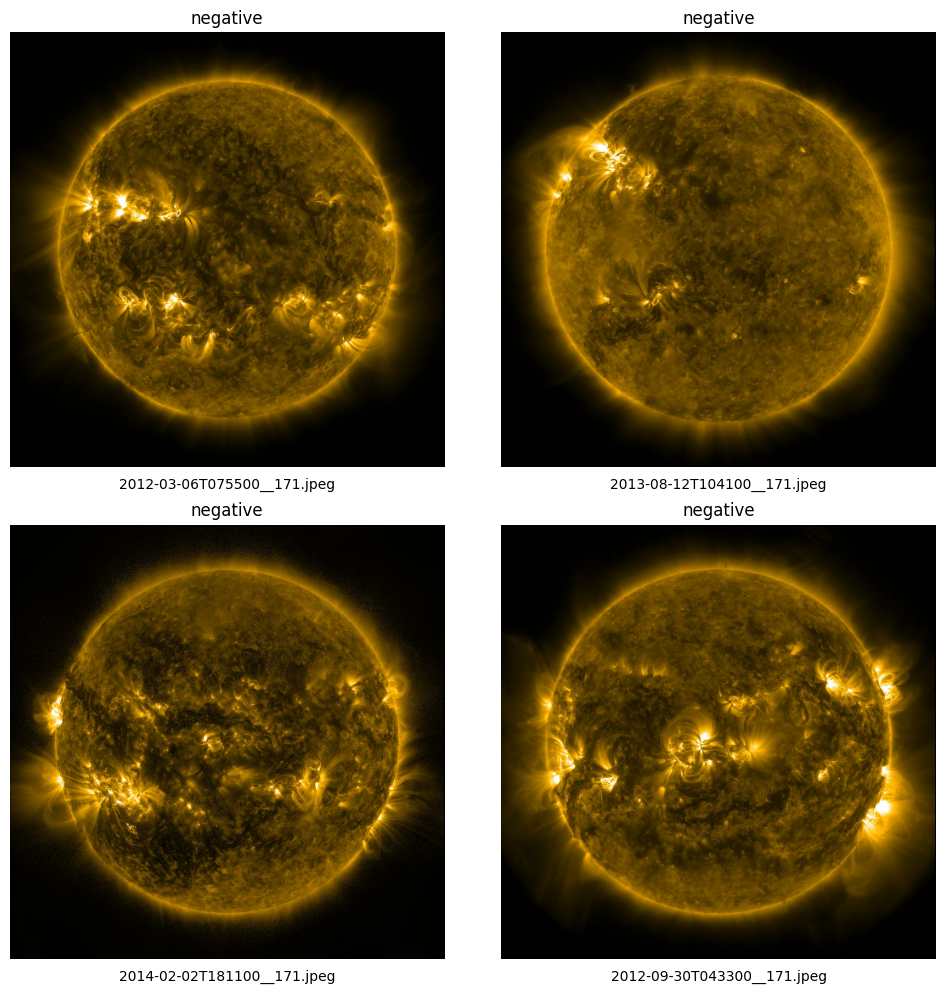

In [28]:
# Define the number of rows and columns in the subplot grid
num_rows, num_cols = 2, 2
num_images = num_rows * num_cols

# Create a figure for the subplots
plt.figure(figsize=(10, 10))

for i, (images, labels) in enumerate(data.take(num_images)):
    ax = plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(images[0].numpy().astype("uint8"))
    plt.title(f'{class_names[int(labels[0])]}')
    plt.axis("off")

    # Extract the file name from the file path
    file_name = os.path.basename(data.file_paths[i])

    # Place the file name under the image
    plt.text(0.5, -0.05, file_name, fontsize=10, ha='center', transform=ax.transAxes)

plt.tight_layout()
plt.show()

### Scale the Data
Since these images are in an RGB format it is often very useful to normalize the images. To do this the images are divided by 255.

In [29]:
data = data.map(lambda x,y: (x/255, y))
data

<_MapDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

In [30]:
scaled_data_iterator = data.as_numpy_iterator()
batch = scaled_data_iterator.next()

/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


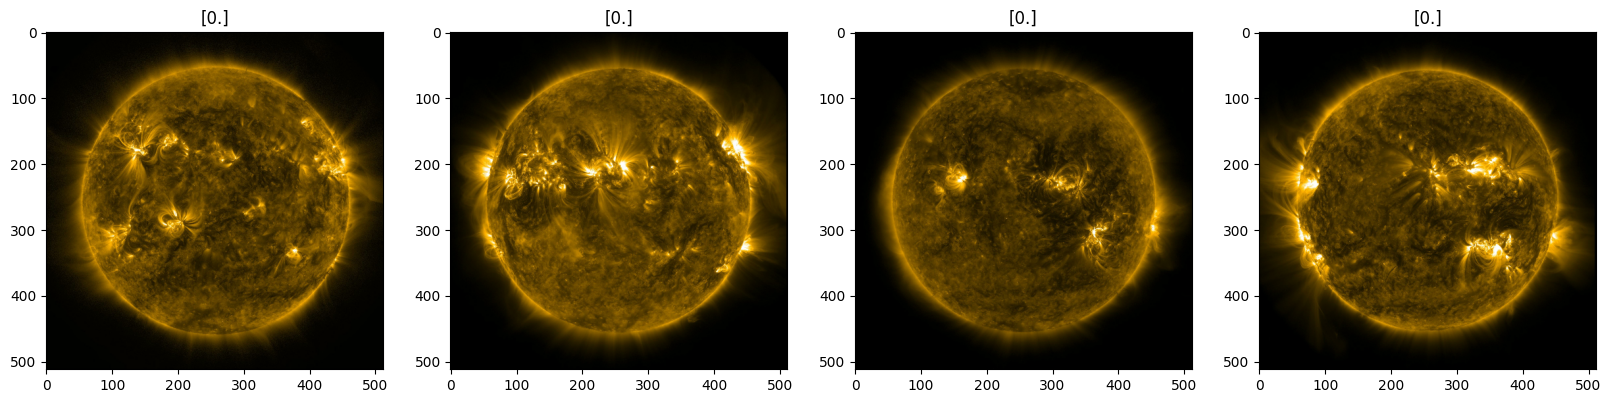

In [31]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

In [32]:
# Create an ImageDataGenerator with data augmentation settings
datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    rescale=1./255
)

### Split Data

In [33]:
len(data)

18

In [34]:
train_size = int(len(data)*.7)
print('trainig batch:', train_size)
val_size = int(len(data)*.2)
print('validation batch:', val_size)
test_size = int(len(data)*.1)
print('test batch:', test_size)

trainig batch: 12
validation batch: 3
test batch: 1


In [35]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [36]:
# train_images = []
# train_labels = []
# for x, y in train:
#     train_images.append(x.numpy())
#     train_labels.append(y.numpy())

# train_images = np.array(train_images)
# train_labels = np.array(train_labels)

# # Apply data augmentation to your training dataset
# batch_size = 32  # You can adjust this batch size as needed
# train_augmented = datagen.flow(train_images, train_labels, batch_size=batch_size)


## Model Architecture
### General Remarks

Since we deal with a very small dataset some preliminary considerations have to be mentioned:
* Small datasets lead to overfitting \\
as one of the most relevant problems with ML models is the so called Bias-Variance tradeoff, or in other words the balance between over-simplification (high bias) and paying too much attention to the training set, such that the model doesn't generalize well.
If a combination of a low bias and high variance is present, one speaks of overfitting the data. On the other hand, if the model shows a high bias and low variance the model underfits the data.
* Using simple models: \\
If only a limited amount of data is available, using a simple model architecture is often better suited as overly complex ones. Additionally regularization techniques can help to avoid overfitting.
* Combining models: \\
combinning some simple models could also help to reduce variance and improve the generalization.
* Use data augmention techniques: \\
As the suggests it, data augmentation techniques use the original data an augment the internal characteristics of the data. Examples in terms of images are: rotation of the image, zooming in/out, flipping the image horizontally or vertically, changning the brightness, etc.

These considerations (and more) have to be made in advance to generate a useful model for a tiny dataset like the present one.

In [37]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3,3), 1, activation='relu'),
    MaxPooling2D(),
    Conv2D(16, (3,3), 1, activation='relu'),
    BatchNormalization(),

    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [38]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 510, 510, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 255, 255, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 253, 253, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 126, 126, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 124, 124, 16)      4624      
                                                                 
 batch_normalization (BatchN  (None, 124, 124, 16)     6

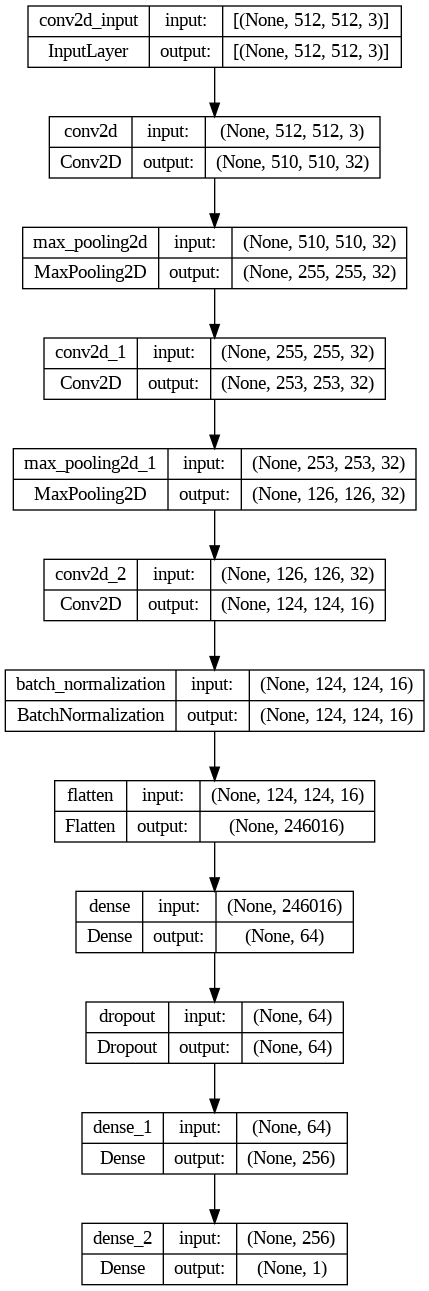

In [41]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='02_sdo_binclass/models/bin_class_model.png', show_shapes=True, show_layer_names=True)

## Training

In [42]:
logdir= working_dir + '/logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

In [43]:
hist = model.fit(train, epochs=100, validation_data=val, callbacks=[tensorboard_callback, early_stopping_callback])

Epoch 1/100
12/12 [==============================] - 19s 364ms/step - loss: 3.6336 - accuracy: 0.6771 - val_loss: 0.9994 - val_accuracy: 0.2083
Epoch 2/100
12/12 [==============================] - 6s 380ms/step - loss: 1.2768 - accuracy: 0.7057 - val_loss: 0.9094 - val_accuracy: 0.8333
Epoch 3/100
12/12 [==============================] - 6s 424ms/step - loss: 0.8823 - accuracy: 0.7630 - val_loss: 0.8433 - val_accuracy: 0.7396
Epoch 4/100
12/12 [==============================] - 6s 379ms/step - loss: 0.8597 - accuracy: 0.7865 - val_loss: 0.7609 - val_accuracy: 0.8125
Epoch 5/100
12/12 [==============================] - 7s 444ms/step - loss: 0.8287 - accuracy: 0.8021 - val_loss: 0.6973 - val_accuracy: 0.8125
Epoch 6/100
12/12 [==============================] - 6s 414ms/step - loss: 0.7870 - accuracy: 0.8151 - val_loss: 0.7290 - val_accuracy: 0.7917
Epoch 7/100
12/12 [==============================] - 6s 382ms/step - loss: 0.7061 - accuracy: 0.8359 - val_loss: 0.7296 - val_accuracy: 0.833

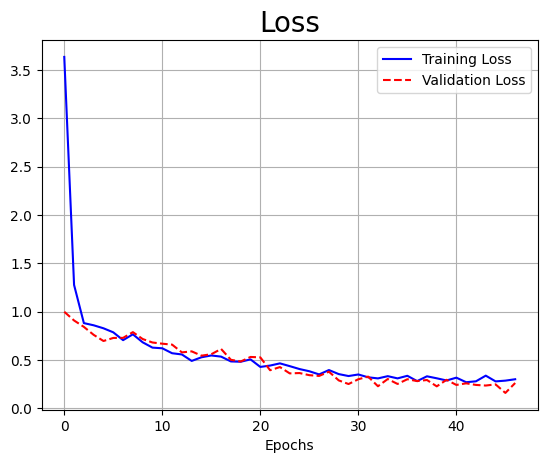

In [52]:
fig, ax = plt.subplots()

# Plot the training loss with a solid line in teal
ax.plot(hist.history['loss'], color='blue', label='Training Loss')

# Plot the validation loss with a dotted line in orange
ax.plot(hist.history['val_loss'], color='red', linestyle='--', label='Validation Loss')

# Add labels to the x-axis
ax.set_xlabel('Epochs')

# Add a grid
ax.grid(True)

# Set the title and legend
ax.set_title('Loss', fontsize=20)
ax.legend(loc='upper right')

# Save the plot
plt.savefig('02_sdo_binclass/models/bin_class_loss.png')
# Display the graph
plt.show()

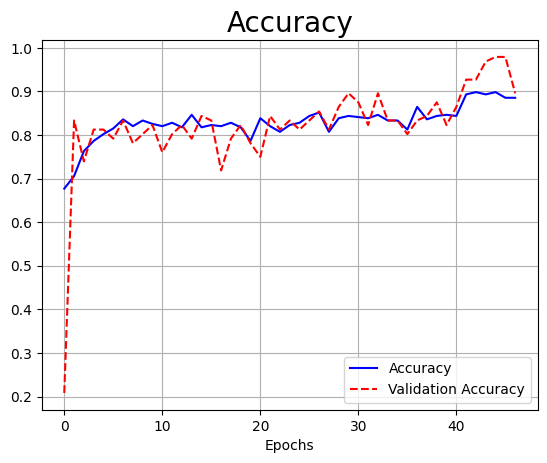

In [54]:
fig, ax = plt.subplots()

# Plot the accuracy with a solid line in blue
ax.plot(hist.history['accuracy'], color='blue', label='Accuracy')

# Plot the validation loss with a dotted line in orange
ax.plot(hist.history['val_accuracy'], color='red', linestyle='--', label='Validation Accuracy')

# Add labels to the x-axis
ax.set_xlabel('Epochs')

# Add a grid
ax.grid(True)

# Set the title and legend
ax.set_title('Accuracy', fontsize=20)
ax.legend(loc='lower right')

# Save the plot
plt.savefig('02_sdo_binclass/models/bin_class_accuracy.png')
# Display the graph
plt.show()

## Evaluation

In [57]:
%%capture
pip install scikit-plot==0.3.7

In [126]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
import scikitplot as skplt

In [145]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [154]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 109ms/step


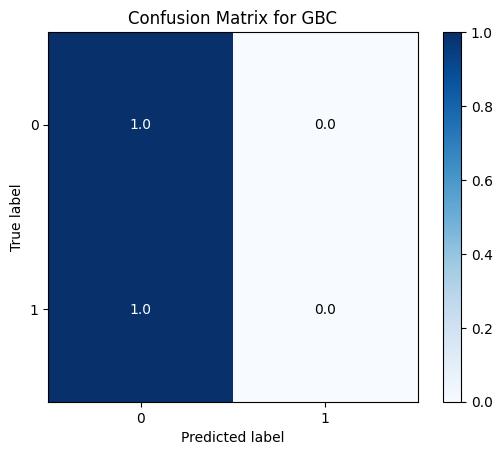

In [157]:
# Check for non-binary values
non_binary_y_hat = [val for val in y_hat if val != 0 and val != 1]
non_binary_y = [val for val in y if val != 0 and val != 1]

if non_binary_y_hat or non_binary_y:
    print("Non-binary values detected in y_hat or y.")
else:
    # Convert to integers
    y_hat = y_hat.astype(int)
    y = y.astype(int)

    # Plot the confusion matrix
    skplt.metrics.plot_confusion_matrix(y, y_hat, normalize=True, title='Confusion Matrix for GBC')


In [143]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision:1.0, Recall:0.625, Accuracy:0.90625


IndexError: ignored

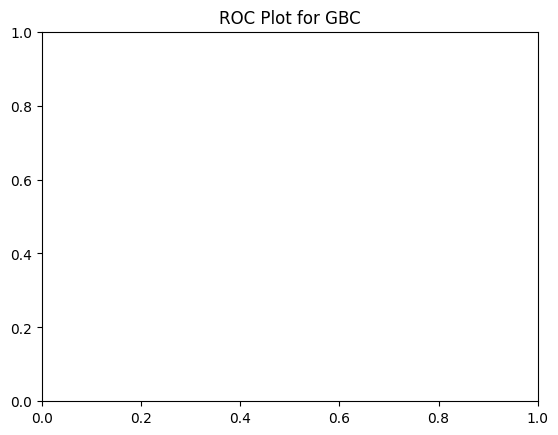

In [142]:
skplt.metrics.plot_roc(y, y_hat, title = 'ROC Plot for GBC')

## Test

load a random image which the model has never seen before:

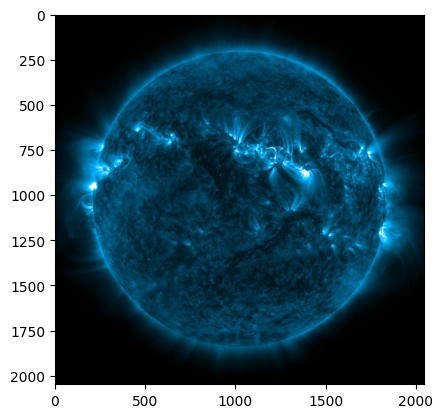

In [293]:
import cv2
img = cv2.imread('00_Dataset/Liu2020_sampled/test_12/neg/2016-02-11T233410__171.jpeg')
#img = cv2.imread('00_Dataset/Liu2020_sampled/test_12/pos/2016-04-17T124641__171.jpeg')
plt.imshow(img)
plt.show()

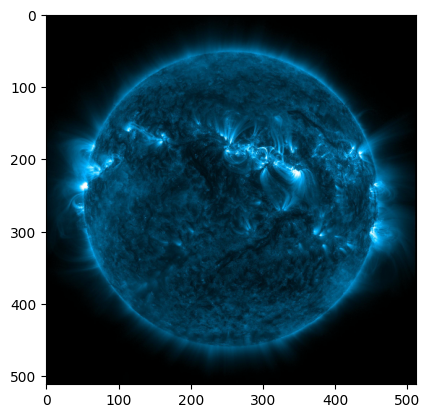

In [294]:
resize = tf.image.resize(img, input_shape[:2])
plt.imshow(resize.numpy().astype(int))
plt.show()

In [295]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 27ms/step


In [296]:
yhat

array([[5.923778e-19]], dtype=float32)

In [297]:
if yhat > 0.5:
    print(f'Predicted class is positve')
else:
    print(f'Predicted class is negative')

Predicted class is negative


## Save the Model


In [279]:
from tensorflow.keras.models import load_model

In [280]:
!ls

 00_Dataset		   03_sdo_ConvLSTM
 01_sdo_data_exploration   04_Tests
 02_sdo_binclass	  'Master Thesis-ML-Project-Checklist.gdoc'


In [286]:
model.save(os.path.join('02_sdo_binclass/models/','imageclassifier.h5'))

In [298]:
new_model = load_model('02_sdo_binclass/models/imageclassifier.h5')
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 97ms/step


array([[5.923778e-19]], dtype=float32)

## Conclusion

TBD